In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def read_data(file_name):
  df = pd.read_csv(f'/content/drive/My Drive/DeepLearning/crypto_data/{file_name}.csv', names=['time', 'low', 'high', 'open', 'close', 'volume'])
  df.set_index('time', inplace=True)
  return df 

In [4]:
file_names = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']

In [5]:
bch_df = read_data(file_names[0])
btc_df = read_data(file_names[1])
eth_df = read_data(file_names[2])
ltc_df = read_data(file_names[3])

In [6]:
btc_df.head()

,low,high,open,close,volume
time,,,,,
1528968660,6489.549805,6489.560059,6489.560059,6489.549805,0.587100
1528968720,6487.370117,6489.560059,6489.549805,6487.379883,7.706374
1528968780,6479.410156,6487.370117,6487.370117,6479.410156,3.088252
1528968840,6479.410156,6479.419922,6479.419922,6479.410156,1.404100
1528968900,6475.930176,6479.979980,6479.410156,6479.979980,0.753000


In [7]:
def join_df(main_df, input_df, crypto_name):
  
  input_df.rename(columns={'close': f'{crypto_name}_close', 'volume': f'{crypto_name}_volume'}, inplace=True)
  input_df = input_df[[f'{crypto_name}_close', f'{crypto_name}_volume']]

  if len(main_df) == 0:
    main_df = input_df
  else:
    main_df = main_df.join(input_df)

  return main_df

In [8]:
all4_df = pd.DataFrame()

all4_df = join_df(all4_df, bch_df, 'BCH')
all4_df = join_df(all4_df, btc_df, 'BTC')
all4_df = join_df(all4_df, eth_df, 'ETH')
all4_df = join_df(all4_df, ltc_df, 'LTC')

In [9]:
all4_df.fillna(method="ffill", inplace=True)
all4_df.dropna(inplace=True)

In [10]:
all4_df.head()

,BCH_close,BCH_volume,BTC_close,BTC_volume,ETH_close,ETH_volume,LTC_close,LTC_volume
time,,,,,,,,
1528968720,870.859985,26.856577,6487.379883,7.706374,486.01001,26.019083,96.660004,314.387024
1528968780,870.099976,1.124300,6479.410156,3.088252,486.00000,8.449400,96.570000,77.129799
1528968840,870.789978,1.749862,6479.410156,1.404100,485.75000,26.994646,96.500000,7.216067
1528968900,870.000000,1.680500,6479.979980,0.753000,486.00000,77.355759,96.389999,524.539978
1528968960,869.989990,1.669014,6480.000000,1.490900,486.00000,7.503300,96.519997,16.991997


### Technical Indicators

In [11]:
def technical_indicators(dataset):

    adjClose = dataset['LTC_close']

    # Create 7 and 21 days Moving Average
    dataset['ma7'] = adjClose.rolling(window=7).mean()
    dataset['ma21'] = adjClose.rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = adjClose.ewm(span=26).mean()
    dataset['12ema'] = adjClose.ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = adjClose.rolling(window=20,center=False).std() 
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    # dataset['ema'] = adjClose.ewm(com=0.5).mean()
    
    # # Create RSI
    # delta = adjClose.diff()
    # delta = delta[1:] 

    # up, down = delta.copy(), delta.copy()
    # up[up < 0] = 0
    # down[down > 0] = 0

    # # Calculate the SMA
    # roll_up = up.rolling(14).mean()
    # roll_down = down.abs().rolling(14).mean()

    # # Calculate the RSI based on SMA
    # RS = roll_up / roll_down
    # dataset['RSI'] = 100.0 - (100.0 / (1.0 + RS))
    
    return dataset

In [12]:
all4_df = technical_indicators(all4_df)

In [13]:
# Remove the first 20 values in order to have no NaN
all4_df = all4_df[20:]
all4_df.head()

,BCH_close,BCH_volume,BTC_close,BTC_volume,ETH_close,ETH_volume,LTC_close,LTC_volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band
time,,,,,,,,,,,,,,,,
1528969920,873.650024,1.198600,6486.359863,1.065600,488.00000,101.905365,96.629997,65.206299,96.518570,96.478571,96.487900,96.508591,0.020691,0.075913,96.630396,96.326746
1528969980,873.859985,1.293300,6487.259766,0.602759,487.98999,303.575714,96.599998,206.481979,96.547141,96.475714,96.498075,96.523019,0.024944,0.078263,96.632239,96.319189
1528970040,873.750000,7.357900,6487.270020,0.427600,488.00000,20.277039,96.639999,35.712299,96.578570,96.479047,96.510746,96.541411,0.030664,0.086789,96.652626,96.305468
1528970100,873.309998,2.864491,6490.000000,0.516043,487.98999,20.961819,96.660004,119.928459,96.591427,96.486666,96.523872,96.559993,0.036121,0.093147,96.672961,96.300372
1528970160,873.309998,0.149200,6490.000000,0.742156,488.00000,19.020500,96.660004,27.055300,96.615714,96.499524,96.535680,96.575619,0.039939,0.100382,96.700287,96.298760


### Create Label

In [14]:
SEQ_LEQ = 30
FORECAST_PERIOD = 1

In [15]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [16]:
all4_df['Future'] = all4_df['LTC_close'].shift(-FORECAST_PERIOD)
all4_df['Label'] = list(map(classify, all4_df['LTC_close'], all4_df['Future']))

In [17]:
all4_df.head()

,BCH_close,BCH_volume,BTC_close,BTC_volume,ETH_close,ETH_volume,LTC_close,LTC_volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,Future,Label
time,,,,,,,,,,,,,,,,,,
1528969920,873.650024,1.198600,6486.359863,1.065600,488.00000,101.905365,96.629997,65.206299,96.518570,96.478571,96.487900,96.508591,0.020691,0.075913,96.630396,96.326746,96.599998,0
1528969980,873.859985,1.293300,6487.259766,0.602759,487.98999,303.575714,96.599998,206.481979,96.547141,96.475714,96.498075,96.523019,0.024944,0.078263,96.632239,96.319189,96.639999,1
1528970040,873.750000,7.357900,6487.270020,0.427600,488.00000,20.277039,96.639999,35.712299,96.578570,96.479047,96.510746,96.541411,0.030664,0.086789,96.652626,96.305468,96.660004,1
1528970100,873.309998,2.864491,6490.000000,0.516043,487.98999,20.961819,96.660004,119.928459,96.591427,96.486666,96.523872,96.559993,0.036121,0.093147,96.672961,96.300372,96.660004,0
1528970160,873.309998,0.149200,6490.000000,0.742156,488.00000,19.020500,96.660004,27.055300,96.615714,96.499524,96.535680,96.575619,0.039939,0.100382,96.700287,96.298760,96.660004,0


### Creating Sequences

In [18]:
train_samples = int(all4_df.shape[0] * 0.9)

train_ = all4_df.iloc[:train_samples]
validation_ = all4_df.iloc[train_samples:]

In [19]:
import random
from collections import deque
from sklearn import preprocessing

In [20]:
def preprocess(df):

    df = df.drop('Future', 1)

    for col in df.columns: 
        if col != 'Label': 
            df[col] = df[col].pct_change() 
            df.dropna(inplace=True) 
            df[col] = preprocessing.scale(df[col].values)

    df.dropna(inplace=True)

    sequential_data = [] 
    prev_days = deque(maxlen=SEQ_LEQ)

    for i in df.values:
      prev_days.append([n for n in i[:-1]]) 
      if len(prev_days) == SEQ_LEQ: 
        sequential_data.append([np.array(prev_days), i[-1]]) 

    random.shuffle(sequential_data)

    ups = [] 
    downs = []  

    for seq, label in sequential_data: 
        if label == 1:  
            ups.append([seq, label]) 
        elif label == 0:
            downs.append([seq, label]) 

    random.shuffle(downs) 
    random.shuffle(ups)

    lower = min(len(downs), len(ups))

    ups = ups[:lower]  
    downs = downs[:lower]

    sequential_data = ups+downs  

    random.shuffle(sequential_data) 

    return sequential_data

In [21]:
train_sequences = preprocess(train_)
test_sequences = preprocess(validation_)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

device = "cuda"

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)
torch.manual_seed(0)

### Convert to Tensor

In [23]:
def tensor_converter_e(sequence, label):

  label_tensor = torch.tensor(label).to(device)
  # label_tensor_zero = torch.zeros(1).to(device)
  seq_tensor = torch.tensor(sequence).to(device)

  return seq_tensor, label_tensor.long()
  # return seq_tensor, label_tensor_zero.long()

In [24]:
train_sequences_tensor = [tensor_converter_e(seq, label) for seq, label in train_sequences]
test_sequences_tensor = [tensor_converter_e(seq, label) for seq, label in test_sequences]

#### Data structure

In [ ]:
train_sequences_tensor[0]

(tensor([[ 4.1923e-02, -5.6485e-03,  1.2115e-03, -6.3802e-02, -2.7308e-01,
          -5.3773e-02,  4.0395e-03, -1.1165e-01],
         [ 9.0364e-01, -6.1384e-03, -5.5524e-04, -6.8512e-02, -3.2858e-01,
          -5.5306e-02,  4.0395e-03,  7.1340e-02],
         [ 2.7958e-03, -6.0957e-03, -2.3220e-03, -2.3485e-02,  5.0330e-01,
          -3.1415e-02,  4.0395e-03, -1.1597e-01],
         [ 2.7958e-03, -8.9035e-04,  1.2115e-03, -7.1479e-02, -2.7312e-01,
          -4.0592e-02,  4.0395e-03, -1.0819e-01],
         [ 2.6361e-01, -5.9278e-03, -5.5524e-04, -6.8249e-02,  3.1730e-02,
          -3.5427e-02,  4.0395e-03, -1.0624e-01],
         [ 1.2933e+00, -6.1095e-03, -5.5524e-04,  1.4078e-02, -2.3603e-02,
          -4.9716e-02,  4.0395e-03,  3.1079e-01],
         [-3.2253e-01, -6.1302e-03, -5.5524e-04, -8.4776e-02,  3.1730e-02,
          -4.6949e-02,  4.0395e-03, -1.2291e-01],
         [ 1.5828e-02, -5.9514e-03, -2.3220e-03, -2.7790e-02, -2.3603e-02,
          -5.4876e-02,  4.3260e-01, -1.1877e-01],


In [ ]:
test_sequences_tensor_labelLong[0][1]

tensor(0, device='cuda:0')

##### General setup for models


In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [ ]:
from pprint import pprint

### CNN Model

In [25]:
class cnn(nn.Module):

  def __init__(self):
    super(cnn, self).__init__()

    self.conv1 = nn.Conv1d(30, 64, 5)
    self.conv2 = nn.Conv1d(64, 128, 5)
    self.conv3 = nn.Conv1d(128, 256, 5, stride=2)

    self.dropout = nn.Dropout(0)

    self.fc1 = nn.Linear(512, 64)
    self.fc2 = nn.Linear(64, 2)


  def forward(self, x):

    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))

    x = self.dropout(x)


    x = F.relu(self.conv3(x))

    # print(x[:5])
    # print(len(x[0]))

    # x = [yy for y in x for yy in y]
    x = x.view(-1, x[0].shape[0]*x[0].shape[1])
    # print(x[:5])
    # print(len(x[0]))

    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x

  # def predict(self, x):
  #   logits = self.forward(x)
  #   predictions = torch.argmax(logits, dim=-1)
  #   return predictions

### Trainer Class

In [26]:
class Trainer():

  def __init__(
    self,
    model: nn.Module,
    loss_function,
    optimizer):

    self.model = model
    self.loss_function = loss_function
    self.optimizer = optimizer

  def train(self, train_dataset, 
            valid_dataset, 
            epochs):

    train_loss = 0.0
    for epoch in range(epochs):
      print(f'Epoch {epoch+1}')

      epoch_loss = 0.0
      self.model.train()

      for step, sequence in enumerate(train_dataset):

        tokens = sequence[0].float()
        labels = sequence[1]

        self.optimizer.zero_grad()

        predictions = self.model(tokens)

        # print(f'Predictions shape is {predictions.shape}')
        # print(predictions)

        predictions = predictions.view(-1, predictions.shape[-1])
        labels = labels.view(-1)

        temp_loss = self.loss_function(predictions, labels)

        temp_loss.backward()
        self.optimizer.step()

        epoch_loss += temp_loss.tolist()

        
      avg_epoch_loss = epoch_loss / len(train_dataset)
      train_loss += avg_epoch_loss

      print(f'\t[Epoch: {epoch+1}] Training Loss = {avg_epoch_loss}')
      # writer.add_scalar(' Training Loss', avg_epoch_loss, epoch)

      valid_loss = self.evaluate(valid_dataset)
      
      print(f'\t[Epoch: {epoch+1}] Validation Loss = {valid_loss}')
      # writer.add_scalar('Validation Loss', valid_loss, epoch)

    print('Training has finished')
    
    avg_epoch_loss = train_loss / epochs

    return avg_epoch_loss
  

  def evaluate(self, valid_dataset):

    valid_loss = 0.0
    self.model.eval()

    with torch.no_grad():
      for sequence in valid_dataset:
        tokens = sequence[0].float()
        labels = sequence[1]

        predictions = self.model(tokens)
        predictions = predictions.view(-1, predictions.shape[-1])
        labels = labels.view(-1)

        temp_loss = self.loss_function(predictions, labels)
        # temp_loss = temp_loss.view(tokens.shape[0], -1)
        # temp_loss = temp_loss.sum(dim=-1).mean()
        valid_loss += temp_loss.tolist()
      
    return valid_loss / len(valid_dataset)


  def predict(self, x):

    self.model.eval()
    
    with torch.no_grad():
        logits = self.model(x)
        predictions = torch.argmax(logits, -1)
        return logits, predictions

### F-Score

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [28]:
def f_score(labels, predictions):
  
  print(f'# instances: {len(labels)}')

  p = precision_score(labels, predictions, average='macro')
  r = recall_score(labels, predictions, average='macro')
  f = f1_score(labels, predictions, average='macro')

  print(f'# precision: {p:.4f}')
  print(f'# recall: {r:.4f}')
  print(f'# f1: {f:.4f}')


### Confusion Matrix

In [29]:
def cm_plot(test_label, pred_labels):

  label=[0, 1]

  cm = confusion_matrix(test_label, pred_labels, label)
  print(cm)

  sum_col_cm = np.sum(cm, axis=1, keepdims=True)
  acc_col_cm = (cm / sum_col_cm.astype(float))

  acc_col_cm = [[round(x, 4) for x in xx] for xx in acc_col_cm]
  acc_df = pd.DataFrame(data=acc_col_cm, index=label, columns=label)

  acc_df.index.name = 'ACTUAL LABELS'
  acc_df.columns.name = 'PREDICTED LABELS'
  fig, ax = plt.subplots(figsize=(8,6))
  sns.heatmap(acc_df, annot=acc_col_cm, annot_kws={"size": 15}, fmt='', ax=ax, cmap="YlGnBu")
  plt.show()

### Prepare Batch Data

In [30]:
train_dataset = DataLoader(train_sequences_tensor, batch_size=64)
valid_dataset = DataLoader(test_sequences_tensor, batch_size=64)

In [31]:
model = cnn().cuda()
model

cnn(
  (conv1): Conv1d(30, 64, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(5,), stride=(2,))
  (dropout): Dropout(p=0, inplace=False)
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [32]:
trainer = Trainer(
    model = model,
    loss_function = nn.CrossEntropyLoss(),
    optimizer = optim.Adam(model.parameters()),
)

### Train CNN

In [33]:
trainer.train(train_dataset, valid_dataset, 10)

Epoch 1
	[Epoch: 1] Training Loss = 0.6901352632613409
	[Epoch: 1] Validation Loss = 0.6826716638078877
Epoch 2
	[Epoch: 2] Training Loss = 0.6796298723660147
	[Epoch: 2] Validation Loss = 0.6789348353357876
Epoch 3
	[Epoch: 3] Training Loss = 0.671144709145307
	[Epoch: 3] Validation Loss = 0.6808250078967973
Epoch 4
	[Epoch: 4] Training Loss = 0.6610916424735486
	[Epoch: 4] Validation Loss = 0.6884828420246348
Epoch 5
	[Epoch: 5] Training Loss = 0.646309533567162
	[Epoch: 5] Validation Loss = 0.7022664248943329
Epoch 6
	[Epoch: 6] Training Loss = 0.6276354402241994
	[Epoch: 6] Validation Loss = 0.72694358346509
Epoch 7
	[Epoch: 7] Training Loss = 0.6042376626784264
	[Epoch: 7] Validation Loss = 0.7566946172246746
Epoch 8
	[Epoch: 8] Training Loss = 0.5768549861868469
	[Epoch: 8] Validation Loss = 0.79637591102544
Epoch 9
	[Epoch: 9] Training Loss = 0.5466725288217359
	[Epoch: 9] Validation Loss = 0.8093428290357777
Epoch 10
	[Epoch: 10] Training Loss = 0.5172391326993889
	[Epoch: 10] 

0.6220950771423971

In [39]:
model_save_name = 'cnn_model_drop_epoch50.pth'
path = f"/content/drive/My Drive/DeepLearning/models/{model_save_name}" 
torch.save(model.state_dict(), path)

#### Test

In [34]:
predictions = []
test_labels = []

for i in range(len(test_sequences_tensor)):

  test_elem = test_sequences_tensor[i]
  test_x, test_y = test_elem[0].float(), test_elem[1]
      
  logits, coded_pred = trainer.predict(test_x.unsqueeze(0))
  predictions.append(coded_pred[0].tolist()) 
  test_labels.append(test_y.tolist())

In [58]:
train_predictions = []
train_labels = []

for i in range(len(train_sequences_tensor)):

  train_elem = train_sequences_tensor[i]
  train_x, train_y = train_elem[0].float(), train_elem[1]
      
  logits, train_coded_pred = trainer.predict(train_x.unsqueeze(0))
  train_predictions.append(train_coded_pred[0].tolist()) 
  train_labels.append(train_y.tolist())

In [35]:
f_score(test_labels, predictions)

# instances: 6494
# precision: 0.5319
# recall: 0.5319
# f1: 0.5318


[[1677 1570]
 [1470 1777]]


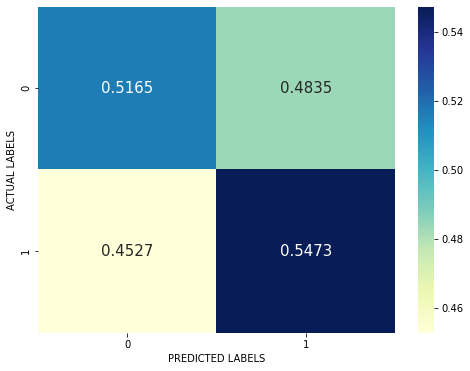

In [36]:
cm_plot(test_labels, predictions)

In [59]:
f_score(train_labels, train_predictions)

# instances: 61768
# precision: 0.8790
# recall: 0.8788
# f1: 0.8788
